In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score
import shap
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('cleaned_transformed_dataset.csv')

print(data.head())

   donor_id  visit_id  B cells  BDNF  CD16+ monocytes  CD16+CD14+ monocytes  \
0         1         1     85.9  0.10             2.61                  1.30   
1         2         2      NaN  1.44              NaN                   NaN   
2         3         3     73.2 -1.19             3.89                  3.05   
3         4         4      NaN -0.55              NaN                   NaN   
4         5         5     57.7  1.22             3.10                  1.14   

   CD16+CD14- monocytes  CD16-CD56bright NK cells  CD161+ NK cells  \
0                  1.41                      0.35             75.5   
1                   NaN                       NaN              NaN   
2                  1.04                      1.67             40.7   
3                   NaN                       NaN              NaN   
4                  2.00                      2.71             71.7   

   CD161+ NKT cells  ...  vaccinated_1yr_prior  vaccine_type_1yr_prior  \
0              55.3  ...      

In [3]:
vaccine_response = 'vaccine_response'

columns_to_drop = ['donor_id', 'study_id', 'visit_id', 'visit_year', 'visit_day', 'visit_type_hai', 'mesurment_id']
data = data.drop(columns=columns_to_drop)

data = data.dropna(subset=[vaccine_response])

print(data.columns)
print(data.shape)

Index(['B cells', 'BDNF', 'CD16+ monocytes', 'CD16+CD14+ monocytes',
       'CD16+CD14- monocytes', 'CD16-CD56bright NK cells', 'CD161+ NK cells',
       'CD161+ NKT cells', 'CD161+CD4+ T cells', 'CD161+CD45RA+ Tregs',
       ...
       'vaccinated_1yr_prior', 'vaccine_type_1yr_prior',
       'vaccinated_2yr_prior', 'vaccine_type_2yr_prior',
       'vaccinated_3yr_prior', 'vaccine_type_3yr_prior',
       'vaccinated_4yr_prior', 'vaccine_type_4yr_prior',
       'influenza_infection_history', 'influenza_hospitalization'],
      dtype='object', length=251)
(363, 251)


In [4]:
X = data.drop(vaccine_response, axis=1)
y = data[vaccine_response]
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [5]:

model = XGBClassifier(
        n_estimators=500, 
        random_state=42, 
        eval_metric='auc', 
        enable_categorical=True,
        max_depth=5,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=1,
        gamma=0.1,
        min_child_weight=5,
    )
_ = model.fit(X_train, y_train)

High Responders (1):
Precision: 0.8333333333333334
Recall: 0.5769230769230769
F1-Score: 0.6818181818181818

Low Responders (0):
Precision: 0.8
Recall: 0.9361702127659575
F1-Score: 0.8627450980392157

Overall Metrics:
Accuracy: 0.8082191780821918
ROC AUC: 0.9034369885433715



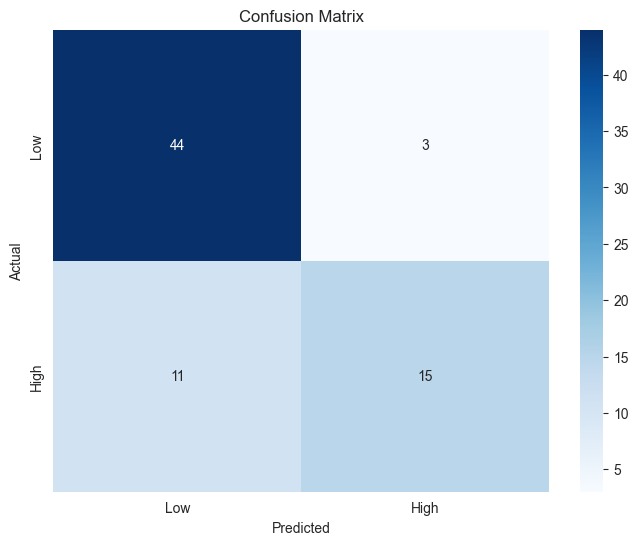


Classification Report:
              precision    recall  f1-score   support

         Low       0.80      0.94      0.86        47
        High       0.83      0.58      0.68        26

    accuracy                           0.81        73
   macro avg       0.82      0.76      0.77        73
weighted avg       0.81      0.81      0.80        73



In [6]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

precision_high = precision_score(y_test, y_pred, pos_label=1)
recall_high = recall_score(y_test, y_pred, pos_label=1)
f1_high = f1_score(y_test, y_pred, pos_label=1)

precision_low = precision_score(y_test, y_pred, pos_label=0)
recall_low = recall_score(y_test, y_pred, pos_label=0)
f1_low = f1_score(y_test, y_pred, pos_label=0)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("High Responders (1):")
print(f"Precision: {precision_high}")
print(f"Recall: {recall_high}")
print(f"F1-Score: {f1_high}")

print("\nLow Responders (0):")
print(f"Precision: {precision_low}")
print(f"Recall: {recall_low}")
print(f"F1-Score: {f1_low}")

print("\nOverall Metrics:")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}\n")

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low', 'High']))

                    Feature  Importance (%)
0                d_geo_mean       32.682178
1                  geo_mean        8.371704
2        CD85j+CD4+ T cells        3.819709
3       CD161+CD45RA+ Tregs        3.223986
4                  L50_IFNB        2.768644
5                     Tregs        2.049580
6         CD27+CD8+ T cells        1.854560
7                L50_PDGFBB        1.736254
8                   T cells        1.706677
9   HLADR-CD38+CD4+ T cells        1.685157
10               L50_RANTES        1.624784
11                     race        1.446030
12                  L50_HGF        1.401735
13                L50_ICAM1        1.390146
14                  B cells        1.371334
15                monocytes        1.282093
16      CD161+CD45RA- Tregs        1.032061
17                 L50_MCSF        1.010121
18        IgD+CD27+ B cells        0.911528
19        CD4+CD27+ T cells        0.891105 



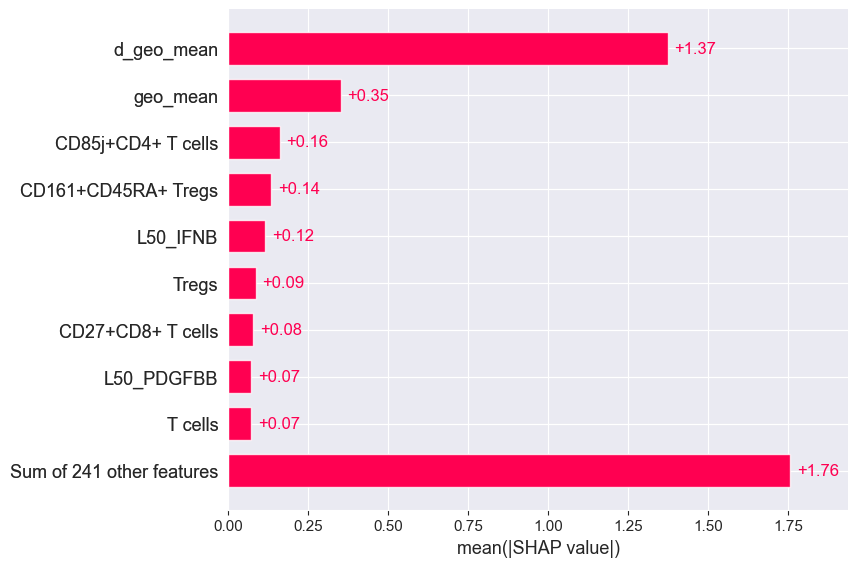

In [7]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)

mean_abs_shap = shap_values_df.abs().mean().sort_values(ascending=False)

importance_percentage = (mean_abs_shap / mean_abs_shap.sum()) * 100

importance_df = pd.DataFrame(importance_percentage).reset_index()
importance_df.columns = ['Feature', 'Importance (%)']
print(importance_df[:20], '\n')

shap.plots.bar(shap_values)

In [10]:
import pickle

with open("fluprint_ai_model.pkl", "wb") as f:
    pickle.dump(model, f)